# All settings will be given to the channel 1 output, in the DC Amp out configuration

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib
import matplotlib.pyplot as plt
import pyvisa as visa
from matplotlib import animation
from time import sleep
from matplotlib.animation import FuncAnimation
#Importing the functions from the module and the pulses dictionaries
from Sweeping import *
from Dictionaries import *
from PulseFiles import *
from Instrument import *
import pyqtgraph as pg 
import nidaqmx

# Visa interface for the M8190A instrument:

In [2]:
M8190A = VisaR(AWG_Settings4,60000)

In [4]:
Initialization(M8190A,AWG_Settings4)

Instruments Sampling Frecuency set to 5.00000000000000E+08Hz
Instruments DC1 Output route Voltage set to 7.00000000000000E-01deciVolts


In [4]:
M8190A.query('*IDN?')

'Agilent Technologies,M8190A,MY57701776,5.6.0.0-2'

In [3]:
M8190A.write('*RST')

5

In [5]:
M8190A.query('FREQ:RAST?')

'5.00000000000000E+08'

In [6]:
M8190A.query('SYST:ERR?')

'0,"No error"'

In [4]:
print(M8190A)

TCPIPInstrument at TCPIP0::ibn3-036.ibn-net.kfa-juelich.de::hislip0::INSTR


# Loading a single waveform:

In [5]:
#triggering related to M8190A.write(':INIT:GATE1 0')
# M8190A.write(':INIT:CONT1 0')
#15ms time length
#maybe I have to modified this function to account for different loops on TRAC subsystem with instrument.write(':TRAC1:COUN L'); with L the number of desired loops

Segment_File(M8190A,"D:\Alejandro\Pulses\Dict\S2\SegmentA_7500000_1.csv",1)


In [5]:
#Trigger mode

M8190A.write(':INIT:GATE1 0')
M8190A.write(':INIT:CONT1 0')
M8190A.write(':ARM:TRIG:IMP HIGH')
M8190A.write('ARM:TRIG:LEV 1')


15

In [6]:
M8190A.write('INIT:IMM')

9

In [8]:
M8190A.write('TRIG:BEG')

9

In [ ]:
Trigger_Pulse('DAQBNC1','ao1',2,4)

In [9]:
M8190A.write('ABOR')

5

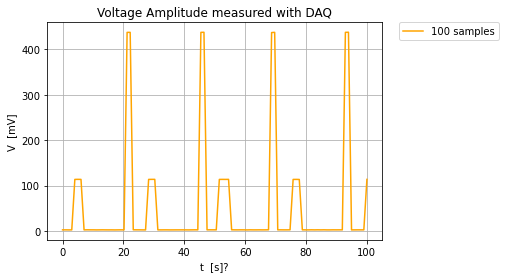

In [22]:
task = nidaqmx.Task()

task.ai_channels.add_ai_voltage_chan("DAQBNC1/ai0",min_val=-4,max_val=4)

task.start()

N = 100


data_on = np.array(task.read(N))



task.stop()
task.close

tom = np.linspace(0,N,N)


fig,ax= plt.subplots()

ax.grid(True)
#plt.plot(tom,data_off,label= 'AWG off')
plt.plot(tom,data_on*1000,label= '{b} samples'.format(b=N),color='orange')

ax.set_ylabel('V  [mV]')
ax.set_xlabel('t  [s]?')
ax.set_title('Voltage Amplitude measured with DAQ')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()
#fig.savefig('Pulse_sweep_t=20',optimize=True,bbox_inches='tight')

In [44]:
data_on.shape

(100,)

# Trigger documentation: AWG manual pp 106
## Sequencing mode either arbitrary or STS

## Trigger Mode in Triggered 

## Advance mode options:
    1. Auto: The segment is executed the number of times specified by its loop count. Then the last sample is played at the end.
    2. Repeat: This advancement mode is quite the same like “Auto” with the difference that an advancement event is required at the end.
    3. Single: An advancement event is required for each segment repetition.
    4. Conditional: The segment is played infinitely after receiving a trigger. After being stopped (See SCPI command :ABORt[1|2]) the offset value is played.

    :ARM:TRIG:LEV 0.4 = 400mV threshold for trigger in, goes from-5V to 5V

In [40]:
val = 0.5
M8190A.write('ARM:TRIG:LEV {v}'.format(v = val))

17

In [37]:
trigger_task.close()

C:\Users\a.hernandez.de.la.ve\Anaconda3\lib\site-packages\nidaqmx\task.py:461: ResourceWarning: Attempted to close NI-DAQmx task of name "_unnamedTask<1D>" but task was already closed.
  warnings.warn(


# TRIG Subsystem:

pp 210 manual

In [10]:
M8190A.query('ARM:TRIG:LEV?')

'5.00000000000000E-01'

Set or query the source for the enable event.
TRIGger - trigger input
EVENt - event input

In [12]:
M8190A.query(':TRIG:SOUR:ENAB?')


'TRIG'

Set or query the hardware input disable state for the enable function. When the hardware input is disabled, an enable event can only be generated using the :TRIGger[:SEQuence][:STARt]:ENABle[1|2][:IMMediate] command. When the hardware input is enabled, an enable event can be generated by command or by a signal present at the trigger or event input.

In [39]:
M8190A.query(':TRIG:ENAB:HWD?')

'1'

In [14]:
M8190A.write(':TRIG:ENAB:HWD 1')

17

In [40]:
M8190A.query(':TRIG:BEG:HWD?')

'1'

Set or query the hardware input disable state for the trigger function. When the hardware input is disabled, a trigger can only be generated using the :TRIGger[:SEQuence][:STARt]:BEGin[1|2][:IMMediate] command. When the hardware input is enabled, a trigger can be generated by command, by a signal present at the trigger input or the internal trigger generator.

In [11]:
M8190A.write('TRIG:BEG:HWD 1')

15

In [43]:
M8190A.query('TRIG:ADV:HWD?')

'1'

In [42]:
M8190A.write('TRIG:ADV:HWD 1')

15

# TRIG -Trigger input pp 212



In [45]:
M8190A.write(':TRIG:SOUR:ADV TRIG')

20

In [46]:
M8190A.query(':TRIG:SOUR:ADV?')

'TRIG'

In [29]:
Trigger_Pulse('DAQBNC1','ao1',2,4)

Done


In [25]:
M8190A.write('INIT:IMM')

9

In [30]:
M8190A.write('ABOR')


5

In [34]:
M8190A.write('TRIG:ENAB') #no idea on what the enabling is 

10

In [9]:
M8190A.write(':TRIG:BEG')

10

In [43]:
M8190A.query('ARM:TRIG:SOUR?')
M8190A.query(':ARM:TRIG:SLOP EITH')

'EXT'

# Pulse Sequence in seconds regime

In [2]:
Sweep(PList_secondsA,5,0,15,1875000000)
7500000

In [3]:
Sequence_Pulse_List(PList_secondsA,PList_secondsB,10,0,15,7500000,M8190A,AWG_Settings4,1)



Current Segment Catalogue is 1,7500000  [(segment id, Segment size)]
Current Segment Catalogue is 1,7500000,2,7500000  [(segment id, Segment size)]
Sequence loaded with the following segment data "1,1,0,1,0,7499999,2,1,0,1,0,7499999"


(0,
                Y1  SyncMarker1  SampleMarker1
 0        0.000000            1              1
 1        0.857143            1              1
 2        0.857143            1              1
 3        0.857143            1              1
 4        0.857143            1              1
 ...           ...          ...            ...
 7499995  0.000000            1              1
 7499996  0.000000            1              1
 7499997  0.000000            1              1
 7499998  0.000000            1              1
 7499999  0.000000            1              1
 
 [7500000 rows x 3 columns],
                Y1  SyncMarker1  SampleMarker1
 0        0.000000            0              0
 1        0.857143            0              0
 2        0.857143            0              0
 3        0.857143            0              0
 4        0.857143            0              0
 ...           ...          ...            ...
 7499995  0.000000            0              0
 7499996  0.000000       

In [4]:
M8190A.write(':INIT:GATE1 0')
M8190A.write(':INIT:CONT1 0')
M8190A.write(':ARM:TRIG:IMP HIGH')
M8190A.write('ARM:TRIG:LEV 1')

15

In [16]:
Trigger_Pulse('DAQBNC1','ao1',2,3)

Done


In [8]:
M8190A.write('TRIG:BEG')

9

In [32]:
125000000*15

1875000000

In [33]:
1875000000/480

3906250.0

In [44]:
M8190A.query('ARM:TRIG:LEV?')

'5.00000000000000E-01'

In [47]:
DataFramesPSscheme['SegmentA_7500000_1']

,Y1,SyncMarker1,SampleMarker1
0,0.000000,1,1
1,0.571429,1,1
2,0.571429,1,1
3,0.571429,1,1
4,0.571429,1,1
...,...,...,...
7499995,0.000000,1,1
7499996,0.000000,1,1
7499997,0.000000,1,1
7499998,0.000000,1,1


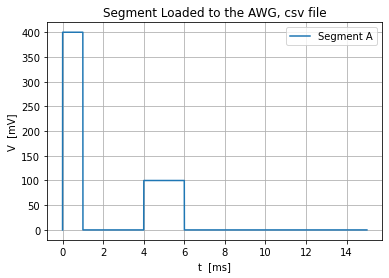

In [51]:
fig,ax= plt.subplots()

ax.grid(True)

plt.plot(timeinterval,DataFramesPSscheme['SegmentA_7500000_1']['Y1']*AWG_Settings2['Voltage Amplitude'],label= 'Segment A')
ax.set_ylabel('V  [mV]')
ax.set_xlabel('t  [ms]')
ax.set_title('Segment Loaded to the AWG, csv file')
ax.legend(loc=0)
plt.show()
#fig.savefig('Pulse_sweep_t=20',optimize=True,bbox_inches='tight')

In [13]:
#Dummy version below!


tic = time.time()

DataFramesPSscheme, DataFramesPSschemes2 , timeinterval = Sequence_Loader_List(PScheme,PScheme2,5,15,7500000,0,5,M8190A,AWG_Settings2,1,10)

toc = time.time()

dur = toc -tic

KeyboardInterrupt: 

# Dummy function

In [5]:
#dummy function

tic = time.time()

DataFramesPSscheme, DataFramesPSschemes2 , timeinterval = Sequence_Loader_List_D(PScheme,PScheme2,5,15,7500000,3,5,M8190A,AWG_Settings2,1,10)

toc = time.time()

dur = toc -tic

Sequence loaded with the following segment data "1,1,0,1,0,7499999,2,1,0,1,0,7499999"
Dummy Segment loading ended
Sequence loaded with the following segment data "1,1,0,1,0,7499999,2,1,0,1,0,7499999"
Sequence loaded with the following segment data "1,1,0,1,0,7499999,2,1,0,1,0,7499999"
Sequence loaded with the following segment data "1,1,0,1,0,7499999,2,1,0,1,0,7499999"


In [8]:
dur

120.69200253486633

In [11]:
DataFramesPSscheme

{'SegmentA_7500000_3':                Y1  SyncMarker1  SampleMarker1
 0        0.000000            1              1
 1        0.666667            1              1
 2        0.666667            1              1
 3        0.666667            1              1
 4        0.666667            1              1
 ...           ...          ...            ...
 7499995  0.000000            1              1
 7499996  0.000000            1              1
 7499997  0.000000            1              1
 7499998  0.000000            1              1
 7499999  0.000000            1              1
 
 [7500000 rows x 3 columns],
 'SegmentA_7500000_4':                Y1  SyncMarker1  SampleMarker1
 0        0.000000            1              1
 1        0.666667            1              1
 2        0.666667            1              1
 3        0.666667            1              1
 4        0.666667            1              1
 ...           ...          ...            ...
 7499995  0.000000            1 

In [7]:
M8190A.query('SYST:ERR?')

'-300,"Device-specific error;CH1: Waveform file ""SegmentA_7500000_3.csv"" not found."'

In [2]:
AWG_Settings2

{'Visa Resource Name': 'TCPIP0::ibn3-036.ibn-net.kfa-juelich.de::hislip0::INSTR',
 'Voltage Amplitude': 300,
 'Clock Sample Frecuency': 500000000,
 'Output_Channel': 1,
 'Mode': 'STS',
 'Output_rout': 'DC',
 'Data Directory': 'D:\\Alejandro\\Pulses\\Dict\\S2'}

In [9]:
AWG_Settings2['Data Directory']

'D:\\Alejandro\\Pulses\\Dict\\S2'

In [5]:
type(_)

str

In [ ]:
Sequence_File(instrument,r'D:\\Alejandro\\Pulses\\Dict\\S2\\SegmentA_{a}_{b}.csv'.format(a =N,b=start),r'D:\\Alejandro\\Pulses\\Dict\\S2\\SegmentB_{a}_{b}.csv'.format(a = N,b= start),1)

In [12]:
strnga=r'{directory}\SegmentA_{a}_{b}.csv'.format(directory = AWG_Settings2['Data Directory'], a=5, b= 0)

In [13]:
strnga

'D:\\Alejandro\\Pulses\\Dict\\S2\\SegmentA_5_0.csv'

In [14]:
'{aber}'.format(aber = strnga)

'D:\\Alejandro\\Pulses\\Dict\\S2\\SegmentA_5_0.csv'

In [31]:
trigger_task = nidaqmx.Task()

trigger_task.ao_channels.add_ao_voltage_chan('DAQBNC1/ao1','triggering',0,4)
trigger_task.start()

val = 0

trigger_task.write(val)

trigger_task.stop()
trigger_task.close()